Text classification with keras (imdb example)
=============================================
From : https://www.tensorflow.org/tutorials/keras/basic_text_classification

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib

import deepmods.notebook as ooo

ooo.init(id='22.3', save_figs=True)


Deepmod by pjluc 2019
  Version          : 0.4.1
  Run time         : Monday 16 September 2019, 18:11:03
  Run directory    : ./run/lab-22.3
  Save figs        : True
  Matplotlib style : deepmods/talk.mplstyle
  Hide warning     : True

TensorFlow version :  1.14.0
Keras version      :  2.2.4-tf

Init done.


## Récupération des données
#### Structure des données :  
- data  = \[ critique0, critique1, ...\] avec critique_i=\[ int1, int2, ...\] où int_i=index du mot i dans le dictionnaire
- label = \[ avis0, avis1, ...\] où avis_i=0 si note imdb <= 4 (avis négatif) ou avis_i=1 si note_imdb>=6 (avis positif)
- word_index = \[ mot1:int1, mot2:int2, ... ]
num_words = Nombre de mots les plus frequemment utilisés à conserver  

#### Indexation des mots :
- num_words=m : On ne retient que les m mots les plus utilisés
- skip_top=n : On retire les n mots les plus utilisés (Note : pas pratique, car les débuts de phrases sont virés...)
- maxlen=l : On retire les phrases de longueur>l
- Remplissage (padding) : 0
- start_char=1 : Début de prase
- oov_char=2 : Mots retirés
- index_from=k : On commence l'indexation des mots à k  -> Il faudra donc réaligner le dictionaire


In [2]:
imdb = keras.datasets.imdb

# ----- Retrieve x,y
#
(x_train, y_train), (x_valid, y_valid) = imdb.load_data( num_words  = 10000,
                                                         skip_top   = 0,
                                                         maxlen     = 9999,
                                                         start_char = 1,
                                                         oov_char   = 2,
                                                         index_from = 5  )

# x_valid = x_train_and_valid[:10000]     # [0-10000] Validation data
# x_train = x_train_and_valid[10000:]     # [10000-*] Train data

# y_valid = y_train_and_valid[:10000]
# y_train = y_train_and_valid[10000:]


# ----- Retrieve index
#
word_index = imdb.get_word_index()
print('Dataset loaded/cached in ~/.keras/datasets/')

# ----- Reindex and complete dictionary
#
word_index = {k:(v+5) for k,v in word_index.items()} 
word_index["<PAD>"]    = 0
word_index["<START>"]  = 1
word_index["<UNK>"]    = 2 
word_index["<UNUSED>"] = 3

# Reverse dictionary for decoding
#
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def review2text(review):
    return ' '.join([reverse_word_index.get(i, '?') for i in review])

print('Indexes done.')

Dataset loaded/cached in ~/.keras/datasets/
Indexes done.



Corpus d'apprentissage :

  x_train size :  25000
  y_train size :  25000

Corpus de validation :

  x_valid size :  25000
  y_valid size :  25000

Exemple de critique / note :

x_train[9]= [1, 15, 121, 956, 191, 1556, 15, 94, 461, 50, 6, 118, 11, 1494, 2293, 44, 728, 6, 1941, 170, 2033, 15, 425, 16, 22, 551, 20, 6, 2, 549, 34, 6, 98, 41, 6, 456, 9, 6, 24, 10, 6, 57, 132, 170, 15, 94, 361, 8, 160, 1513, 2, 44, 8, 1915, 21, 196, 4457, 4123, 8, 116, 10, 74, 23, 467, 9669, 306, 6, 53, 11, 16, 22, 46, 157, 10, 8, 228, 164, 618, 653, 53, 11, 16, 22, 46, 12, 12, 16, 220, 4845, 631, 44, 3019, 23, 50, 27, 30, 37, 536, 7, 8, 322, 10, 518, 7, 44, 27, 183, 10, 132, 58, 549, 3573, 7, 1473, 853, 16, 2288]

y_train[9]= <START> i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the <UNK> feeling all the way from the beginning of the film to the very end look i don't need a 10 page <UNK> or a sign with big letters explain

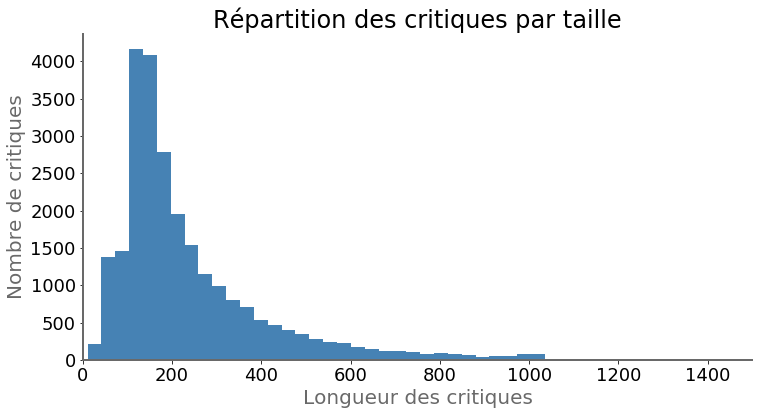

In [3]:
print("\nCorpus d'apprentissage :\n")
print("  x_train size : ", len(x_train))
print("  y_train size : ", len(y_train))

print("\nCorpus de validation :\n")
print("  x_valid size : ", len(x_valid))
print("  y_valid size : ", len(y_valid))

print('\nExemple de critique / note :\n')
print('x_train[9]=',x_train[12])
print('\ny_train[9]=',review2text(x_train[12]))
print('\ny_train[9]=',y_train[12])

print('\nTaille du dictionaire : ',len(word_index))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
ax.hist([len(i) for i in x_train],80 )
ax.set_title('Répartition des critiques par taille')
ax.set_xlim(left=0,right=1500)
ax.set_xlabel('Longueur des critiques')
ax.set_ylabel('Nombre de critiques')
ooo.save_fig("SizeOfReviews")
plt.show()

## Padding des entrées
Afin de pouvoir être traitées par un NN, toutes les entrées doivent avoir la même longueur.  
On va donc les compléter avec un rembourrage (padding) de '&lt;PAD&gt;' (index=0)

In [4]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

x_valid = keras.preprocessing.sequence.pad_sequences(x_valid,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

print('Exemple :\n',x_train[9],'\n')
print(review2text(x_train[9]))

Exemple :
 [   1   16   22   49  113  441 3447   21   14   17  168   14  218  127
   42    8  366  354  709 1189   41  296   13   24  398   15   30   10
  204   14 1111   25   96    2  153  113  213  471    6   22   15  260
  548 1106 7275   14   18   40   80   35  213   17   14   18 2851   65
   95   14    8  255  108   12   12   50  337  269   20    8  366 1244
 1181   22   21    8 1011    9 1989  191    7    8 8421    9 2725    2
   97 1721    8 6037    9 3914 7146   51  371  122    7   30   51  255
   12   12   15 1043   21   87  797   17    6  483   11   57   80  809
   11  377   10 1169   10  796   78    9    6   60    7    6  818   11
  245    9   45   52    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

## Construction du modèle
Quelques remarques :
1. GlobalAveragePooling1D : Fait un pooling sur la seconde dimension (batch_size, steps, features) -> (batch_size, features)  
Autrement dit : on moyenne l'ensemble des mots d'une phrase
2. L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer

In [5]:

vocab_size = 10000
n_neurons  = 32

keras.backend.clear_session()

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, n_neurons, input_length=256))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(n_neurons, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks=[]
callbacks.append( keras.callbacks.ModelCheckpoint(ooo.get_check_dir()+'/model{epoch:02d}-{val_acc:.3f}.h5') )
callbacks.append( keras.callbacks.ModelCheckpoint(ooo.get_model_dir()+'/best_model.h5', save_best_only=True) )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


## Entrainement

In [6]:
%%time

n_epochs   = 30
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=callbacks)


Train on 25000 samples, validate on 25000 samples
Epoch 1/30
25000/25000 [==============================] - 2s 64us/sample - loss: 0.6875 - acc: 0.6454 - val_loss: 0.6764 - val_acc: 0.7329
Epoch 2/30
25000/25000 [==============================] - 1s 50us/sample - loss: 0.6473 - acc: 0.7550 - val_loss: 0.6124 - val_acc: 0.7616
Epoch 3/30
25000/25000 [==============================] - 1s 55us/sample - loss: 0.5535 - acc: 0.8071 - val_loss: 0.5085 - val_acc: 0.8162
Epoch 4/30
25000/25000 [==============================] - 1s 52us/sample - loss: 0.4429 - acc: 0.8518 - val_loss: 0.4197 - val_acc: 0.8474
Epoch 5/30
25000/25000 [==============================] - 1s 56us/sample - loss: 0.3601 - acc: 0.8763 - val_loss: 0.3639 - val_acc: 0.8595
Epoch 6/30
25000/25000 [==============================] - 1s 54us/sample - loss: 0.3074 - acc: 0.8914 - val_loss: 0.3325 - val_acc: 0.8680
Epoch 7/30
25000/25000 [==============================] - 1s 53us/sample - loss: 0.2721 - acc: 0.9018 - val_loss: 0.

## Evalulation du modèle

Load best model... Done.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________
None
25000/25000 [==============================] - 1s 21us/sample - loss: 0.2875 - acc: 0.8826


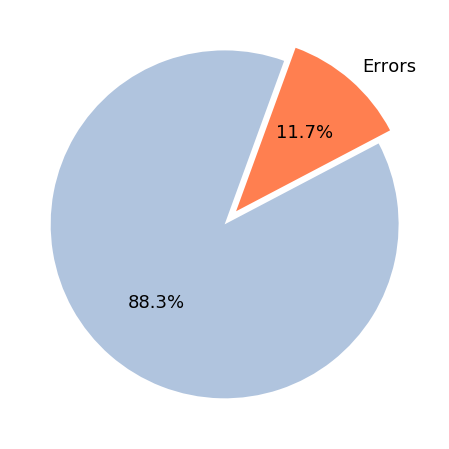

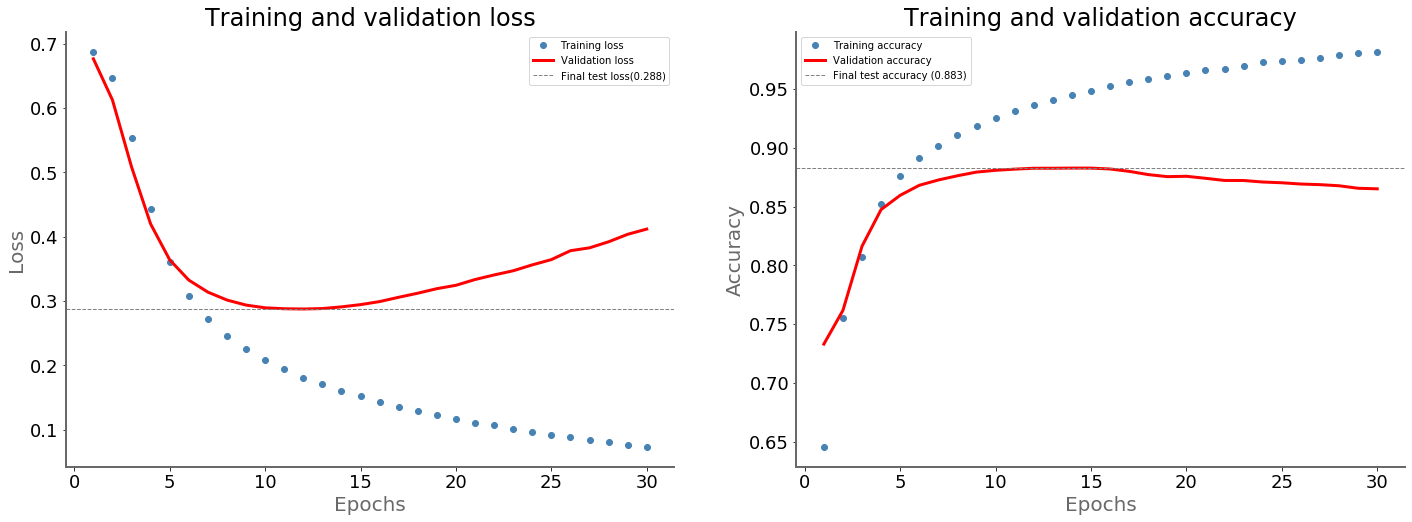

In [8]:
print('Load best model... ', end='')
model = keras.models.load_model(ooo.get_model_dir()+'/best_model.h5')
print('Done.\n')

print(model.summary())
# ------ Evaluation du résultat ------------------------------------

results  = model.evaluate(x_valid, y_valid)
accuracy = results[1]

fig, axs = plt.subplots()
fig.set_size_inches(8,8)
axs.pie([accuracy,1-accuracy], explode=[0,0.1], labels=["","Errors"], 
        autopct='%1.1f%%', shadow=False, startangle=70, 
        colors=["lightsteelblue","coral"], textprops={'fontsize': 18})
ooo.save_fig('accuracy')
plt.show()


# ------ Statistiques d'apprentissage -------------------------------

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
x_epochs = range(1, len(acc) + 1)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(24,8)
ax1.plot(x_epochs, loss,     'o',  fillstyle='full',  markersize=6, color='steelblue', label='Training loss')
ax1.plot(x_epochs, val_loss, '-',  fillstyle='none',  markersize=6, color='red',       label='Validation loss')
ax1.axhline(y=results[0],          linestyle='--',    linewidth=1,  color='grey',      label='Final test loss({:5.3})'.format(results[0]))
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(x_epochs, acc,     'o',  fillstyle='full',  markersize=6, color='steelblue', label='Training accuracy')
ax2.plot(x_epochs, val_acc, '-',  fillstyle='none',  markersize=6, color='red',       label='Validation accuracy')
ax2.axhline(y=results[1],         linestyle='--',    linewidth=1,  color='grey',      label='Final test accuracy ({:5.3})'.format(results[1]))
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

ooo.save_fig("Evaluations")
plt.show()
